In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
def set_plot_params(title, ylabel):
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))


def calculate_ylim(data):
    ylim_min = min(data) - (max(data) - min(data)) * 0.1
    ylim_max = max(data) + (max(data) - min(data)) * 0.1
    return ylim_min, ylim_max


def draw_graph(data: pd.DataFrame, title: str, ylabel: str, date_lst: list, color="blue"):
    '''
    :param data: 시간 인덱스와 그래프로 표시할 정보가 있는 데이터프레임
    :param title: 그래프 제목
    :param ylabel: 그래프 y축 단위
    :param date_lst: 아웃라이어 날짜인덱스 리스트
    :param color: 그래프 색깔
    :return: 
    '''
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data.values, color=color)
    for date in date_lst:
        plt.axvline(pd.to_datetime(date), color='red', linestyle='--', label='Highlight Date')
    set_plot_params(title, ylabel)
    ylim_min, ylim_max = calculate_ylim(list(data.values))
    plt.ylim(ylim_min, ylim_max)
    plt.show()

In [15]:
def compute_CUSUM(X):
    N = len(X)
    CUSUM = np.zeros(N + 1)
    for k in range(1, N + 1):
        CUSUM[k] = CUSUM[k - 1] + X[k - 1] ** 2
    return CUSUM


def compute_gamma(X, T, m):
    gamma = np.zeros(m + 1)
    mean_X = np.mean(X)
    r = X - mean_X  # 잔차 계산
    r_squared = r ** 2
    sigma_squared = np.mean(r_squared)
    for i in range(1, m + 1):
        gamma_i = 0
        for t in range(i + 1, T):
            gamma_i += (r_squared[t] - sigma_squared) * (r_squared[t - i] - sigma_squared)
        gamma[i] = gamma_i / T
    return gamma


def compute_lambda(gamma, m):
    lambda_hat = gamma[0] + 2 * sum((1 - i / (m + 1)) * gamma[i] for i in range(1, m + 1))
    lambda_hat = np.abs(lambda_hat)
    return lambda_hat


def compute_D_prime(CUSUM, T, lambda_hat):
    D_prime = np.zeros(T)
    for k in range(1, T + 1):
        D_prime[k - 1] = (CUSUM[k] - (k / T) * CUSUM[T]) / np.sqrt(lambda_hat)
    return D_prime


def compute_t_star(D_prime, T):
    D_prime_abs = np.abs(D_prime) * np.sqrt(T / 2)
    t_star = np.argmax(D_prime_abs) + 1  # 인덱스는 0부터 시작하므로 +1
    return t_star

In [16]:
N = 1000
T = N
# np.random.seed(0)
# X = np.random.normal(0, 1, N)

np.random.seed(0)
X = np.random.normal(0, 1, N)

#중간에 점프 추가
jump_magnitude = 20
jump_position = N // 2
X[jump_position:] += jump_magnitude

# X = X[:505]
# N = len(X)
# T = N

m = 10

In [17]:
# CUSUM 계산
CUSUM = compute_CUSUM(X)

# gamma 계산
gamma = compute_gamma(X, T, m)

# lambda_hat 계산
lambda_hat = compute_lambda(gamma, m)

In [20]:
print(lambda_hat)

5.079927106684692


In [7]:
# D_prime 계산
D_prime = compute_D_prime(CUSUM, T, lambda_hat)

In [8]:
t_star = compute_t_star(D_prime, T)

In [10]:
print(t_star)

500


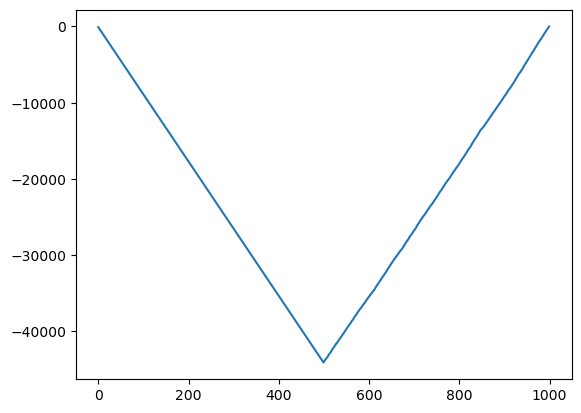

In [11]:
plt.plot(D_prime)

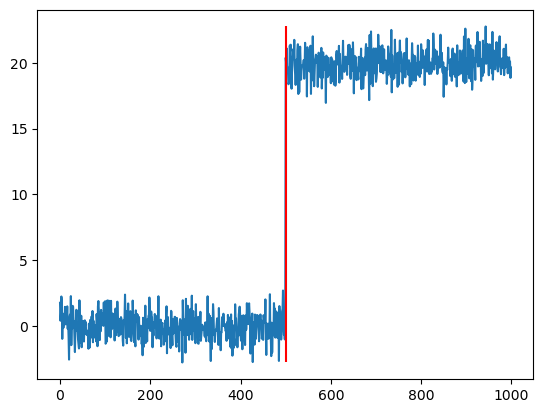

In [22]:
plt.plot(X)
plt.vlines(t_star, min(X), max(X), 'r')

In [24]:
info_wo_tle_df = pd.read_csv('File/info_wo_tle_df.csv', index_col=0)
name = 'perigee'
df = info_wo_tle_df[['year', 'month', 'day', 'hour', name]]

In [25]:
df_1 = df.copy()
df_1.loc[:, 'datetime'] = pd.to_datetime(df_1[['year', 'month', 'day', 'hour']])
df_1.set_index('datetime', inplace=True)
df_1.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
df_1 = df_1.resample('h').mean()

In [26]:
if name == 'altitude' or 'velocity':
    df_2 = df_1.rolling(window=120).mean().dropna()
df_2 = df_1.diff().dropna().values

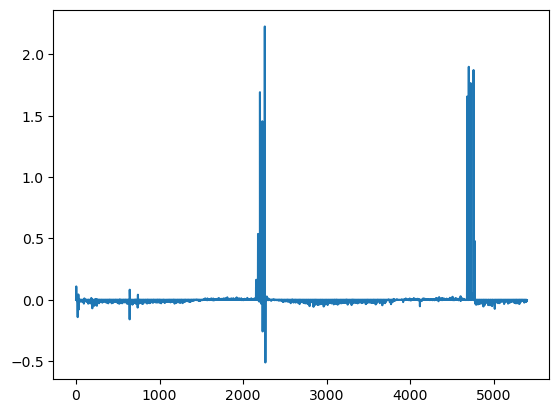

In [27]:
plt.plot(df_2)

In [28]:
ol_points = []
diff_lst = []
t_lst = []
for i in tqdm(range(len(df_2))):
    if i < 100:
        continue
    X = df_2[i - 100:i]
    N = len(X)
    T = N

    # CUSUM 계산
    CUSUM = compute_CUSUM(X)

    # gamma 계산
    gamma = compute_gamma(X, T, m)

    # lambda_hat 계산
    lambda_hat = compute_lambda(gamma, m)

    # D_prime 계산
    D_prime = compute_D_prime(CUSUM, T, lambda_hat)

    t_star = compute_t_star(D_prime, T)
    t_lst.append(t_star)
    diff_lst.append(len(X) - t_star)

    if t_star == len(X) - 1:
        ol_points.append(i)

100%|██████████| 5399/5399 [00:26<00:00, 200.89it/s]


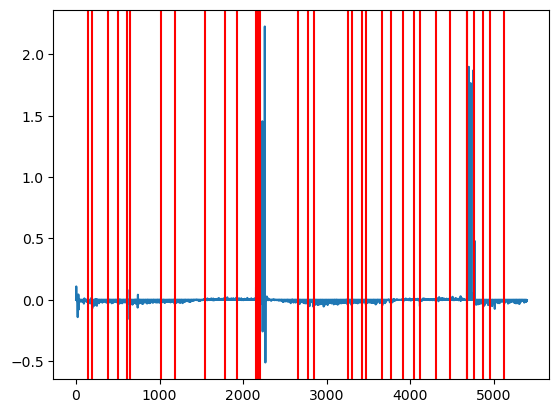

In [29]:
plt.plot(df_2)
for ol_point in ol_points:
    plt.axvline(ol_point, color='r')

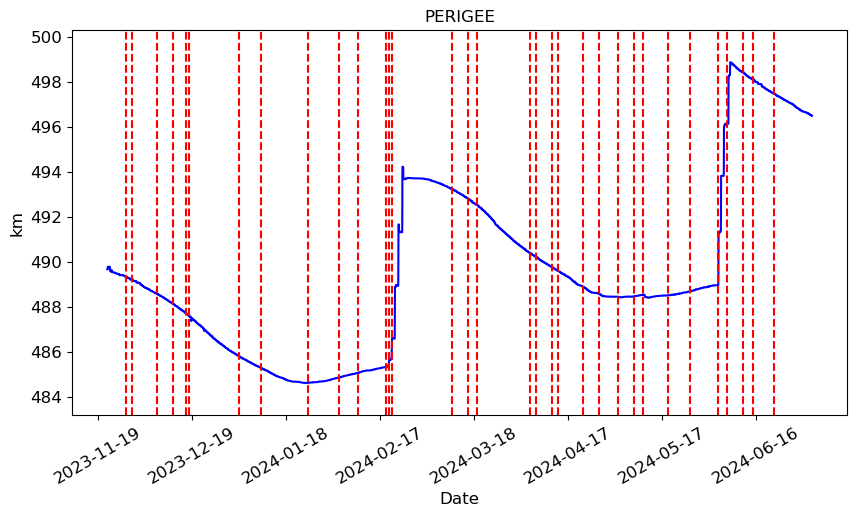

In [32]:
draw_graph(df_1, name.upper(), 'km',
           pd.DataFrame(df_1.iloc[ol_points].index.date).drop_duplicates().values.tolist(), "blue")